In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

### Reading and Displaying Images to train with

In [3]:
# Function to read in images. 
def readImages(dir, pattern):
    """
    Returns an image list with the image contained on the directory `dir` matching the `pattern`.
    """
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + pattern))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), flatten))

vehicles = readImages('./training_data/vehicles', '*.png')
non_vehicles = readImages('./training_data/non-vehicles', '*.png')

#### Example of vehicle and non-vehicle image

Vehicle train image count: 8792
Non-vehicle train image count: 8968


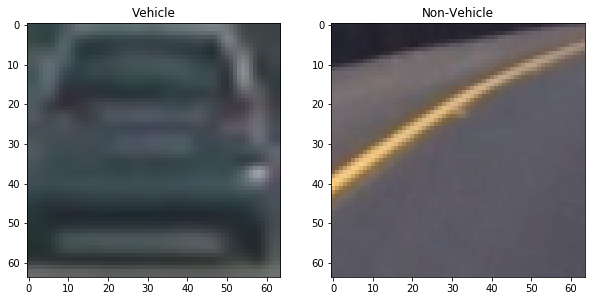

In [4]:
index = 10
vehicle = vehicles[index]
non_vehicle = non_vehicles[index]

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(vehicle)
axes[0].set_title('Vehicle')
axes[1].imshow(non_vehicle)
axes[1].set_title('Non-Vehicle')

print('Vehicle train image count: {}'.format(len(vehicles)))
print('Non-vehicle train image count: {}'.format(len(non_vehicles)))

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, parameters):
    # apply color conversion if other than 'RGB'
    if  parameters.cspace != 'RGB':
        if parameters.cspace == 'HSV':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2HSV)
        elif parameters.cspace == 'LUV':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2LUV)
        elif parameters.cspace == 'HLS':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2HLS)
        elif parameters.cspace == 'YUV':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2YUV)
        elif parameters.cspace == 'YCrCb':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(imgs)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if parameters.hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,parameters.hog_channel], parameters.orient, 
                    parameters.pix_per_cell, parameters.cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, parameters.size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=parameters.hist_bins, bins_range=parameters.hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [6]:
# Define parameters for feature extraction
class FeaturesParameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)

def fitModel( cars, notcars, parameters):
    
    car_features = list(map(lambda img: extract_features(img, parameters), cars))
    notcar_features = list(map(lambda img: extract_features(img, parameters), notcars))


    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
    scaled_X = X_scaler.transform(X) # Apply the scaler to X

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

    # Split up data into randomized training and test setsrand_state = np.random.randint(0, 100)
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


    print('Vector length of Features: {}'.format(len(X_train[0])))
    svc = LinearSVC()
    time_start = time.time()
    svc.fit(X_train, y_train)
    time_end = time.time()
    print('It took {} seconds to train SVC'.format(round(time_end-time_start, 2)))
    print('SVC Test Accuracy: {} '.format(round(svc.score(X_test, y_test), 4))) # Check the score of the SVC
    
    return (svc, X_scaler)

In [7]:
print("okay")
parameters = FeaturesParameters()
svc, scaler = fitModel(vehicles, non_vehicles, parameters)

okay
Vector length of Features: 5568
It took 13.98 seconds to train SVC
SVC Test Accuracy: 0.9873 


#### Showimg examples of HOG images in three channels

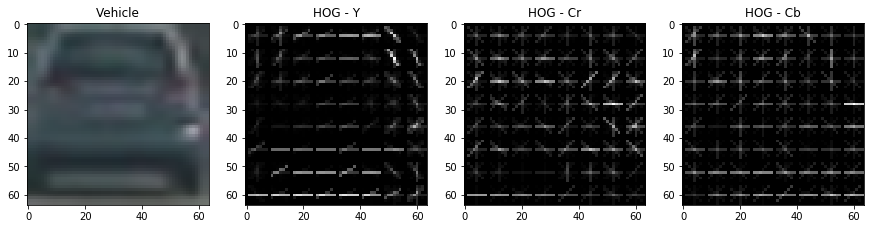

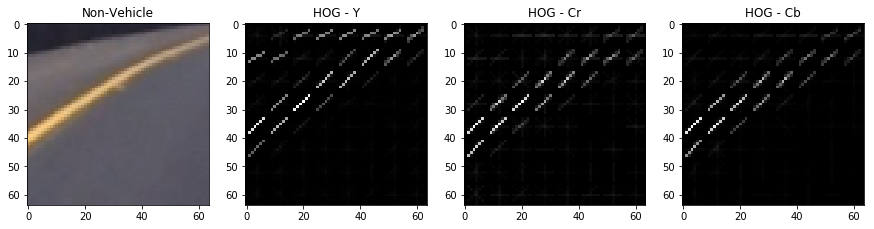

In [8]:
img_cspaced_vehicle = cv2.cvtColor(vehicle, cv2.COLOR_RGB2YCrCb)
img_cspaced_non_vehicle = cv2.cvtColor(non_vehicle, cv2.COLOR_RGB2YCrCb)

_, hog_y_vehicle = get_hog_features(img_cspaced_vehicle[:,:,0], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, 
                                    vis=True, feature_vec=True)
_, hog_Cr_vehicle = get_hog_features(img_cspaced_vehicle[:,:,1], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, 
                                    vis=True, feature_vec=True)
_, hog_Cb_vehicle = get_hog_features(img_cspaced_vehicle[:,:,2], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, 
                                    vis=True, feature_vec=True)
_, hog_y_non_vehicle = get_hog_features(img_cspaced_non_vehicle[:,:,0], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, 
                                    vis=True, feature_vec=True)
_, hog_Cr_non_vehicle = get_hog_features(img_cspaced_non_vehicle[:,:,1], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, 
                                    vis=True, feature_vec=True)
_, hog_Cb_non_vehicle = get_hog_features(img_cspaced_non_vehicle[:,:,2], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, 
                                    vis=True, feature_vec=True)

fig, axes = plt.subplots(ncols=4, figsize=(15,15))
axes[0].imshow(vehicle)
axes[0].set_title('Vehicle')
axes[1].imshow(hog_y_vehicle, cmap='gray')
axes[1].set_title('HOG - Y')
axes[2].imshow(hog_Cr_vehicle, cmap='gray')
axes[2].set_title('HOG - Cr')
axes[3].imshow(hog_Cb_vehicle, cmap='gray')
axes[3].set_title('HOG - Cb')

fig, axes = plt.subplots(ncols=4, figsize=(15,15))
axes[0].imshow(non_vehicle)
axes[0].set_title('Non-Vehicle')
axes[1].imshow(hog_y_non_vehicle, cmap='gray')
axes[1].set_title('HOG - Y')
axes[2].imshow(hog_Cr_non_vehicle, cmap='gray')
axes[2].set_title('HOG - Cr')
axes[3].imshow(hog_Cb_non_vehicle, cmap='gray')
axes[3].set_title('HOG - Cb')

In [9]:
def CarWindowSearch(img, clf, scaler, parameters, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
  
    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, parameters)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

def CarDrawing(img, windows):
    """
    Draw the `windows` on the image `img`.
    """
    output = np.copy(img)
    return draw_boxes(output, windows)

In [10]:
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))
car_on_test = list(map(lambda img: CarDrawing(img, CarWindowSearch(img, svc, scaler, parameters)), test_images))


#### Function to Display Images

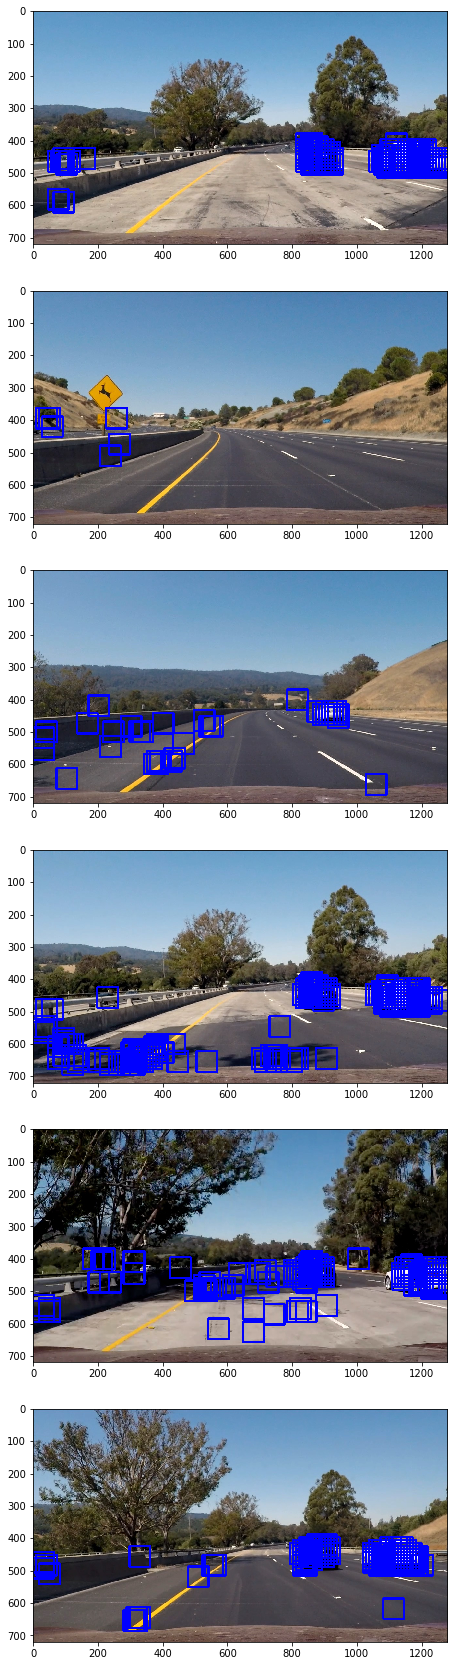

In [11]:
def DisplayImages(images, columns = 1, rows = 6, figsize=(30,30)):
    """
    Display `images` on a [`columns`, `rows`] subplot grid.
    """
    length = len(images)
    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    indexes = range(columns * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < length:
            image = images[index]
            ax.imshow(image)
            
DisplayImages(car_on_test)

### Applying Heat and Thresholding Functions While Also Applying Lables

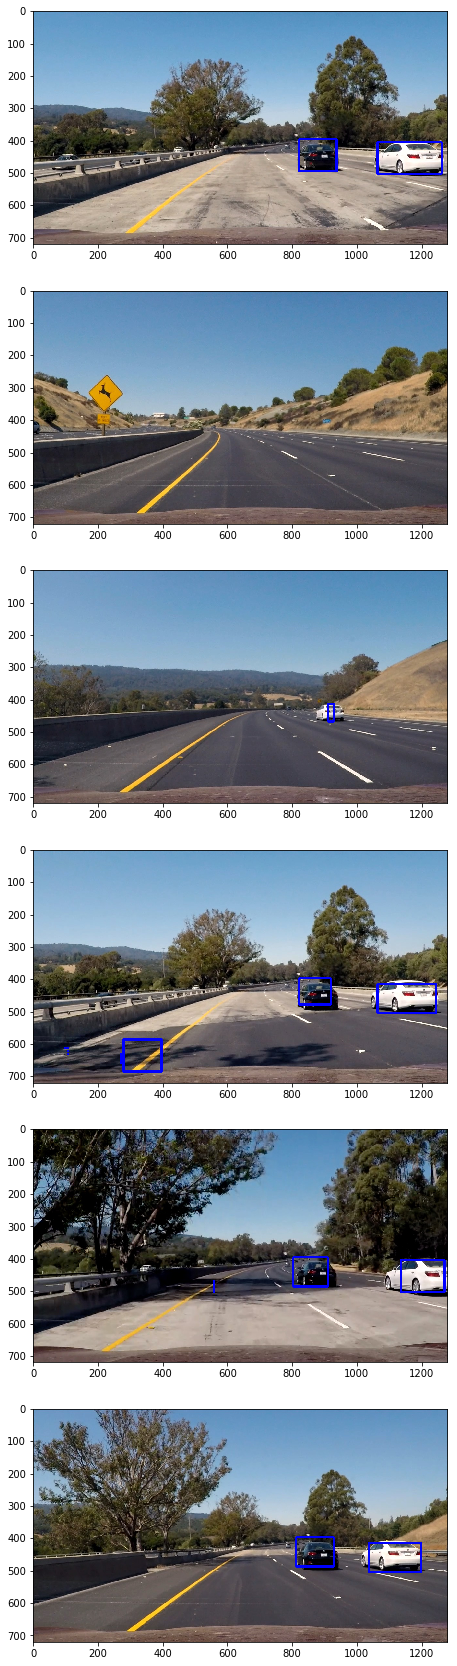

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def HeatAndLabelsOnCars(img, boxes, threshHold = 9):
    """
    Draw the car boxes `boxes` on the image `img` using a heatmap with threshold `threshHold`.
    """
    # Add heat to each box in box list
    heatmap = add_heat(np.zeros(img.shape), boxes)
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshHold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    
    
    return draw_labeled_bboxes(np.copy(img), labels)
    
heatlabels = list(map(lambda img: HeatAndLabelsOnCars(img, CarWindowSearch(img, svc, scaler, parameters)), test_images))

DisplayImages(heatlabels)

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, scaler, parameters, y_start_stop=[350, 656], scale=1.5 ):
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if parameters.cspace != 'RGB':
        if parameters.cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif parameters.cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif parameters.cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif parameters.cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif parameters.cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // parameters.pix_per_cell) - parameters.cell_per_block + 1
    nyblocks = (ch1.shape[0] // parameters.pix_per_cell) - parameters.cell_per_block + 1 
    nfeat_per_block = parameters.orient*parameters.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // parameters.pix_per_cell) - parameters.cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, feature_vec=False)
    
    draw_img = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*parameters.pix_per_cell
            ytop = ypos*parameters.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=parameters.size)
            hist_features = color_hist(subimg, nbins=parameters.hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                draw_img.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img

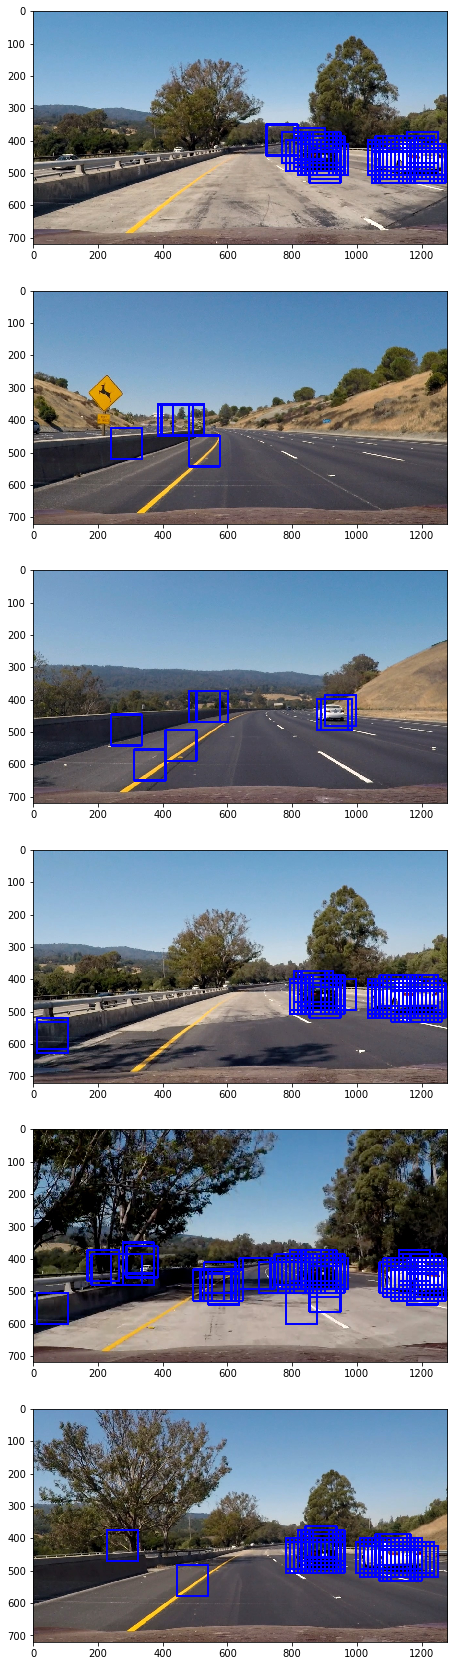

In [14]:
findingcars = list(map(lambda img: find_cars(img, svc, scaler, parameters), test_images))

drawingcars = list(map(lambda BoxandCar: CarDrawing(BoxandCar[0], BoxandCar[1]), zip(test_images, findingcars)))

DisplayImages(drawingcars)

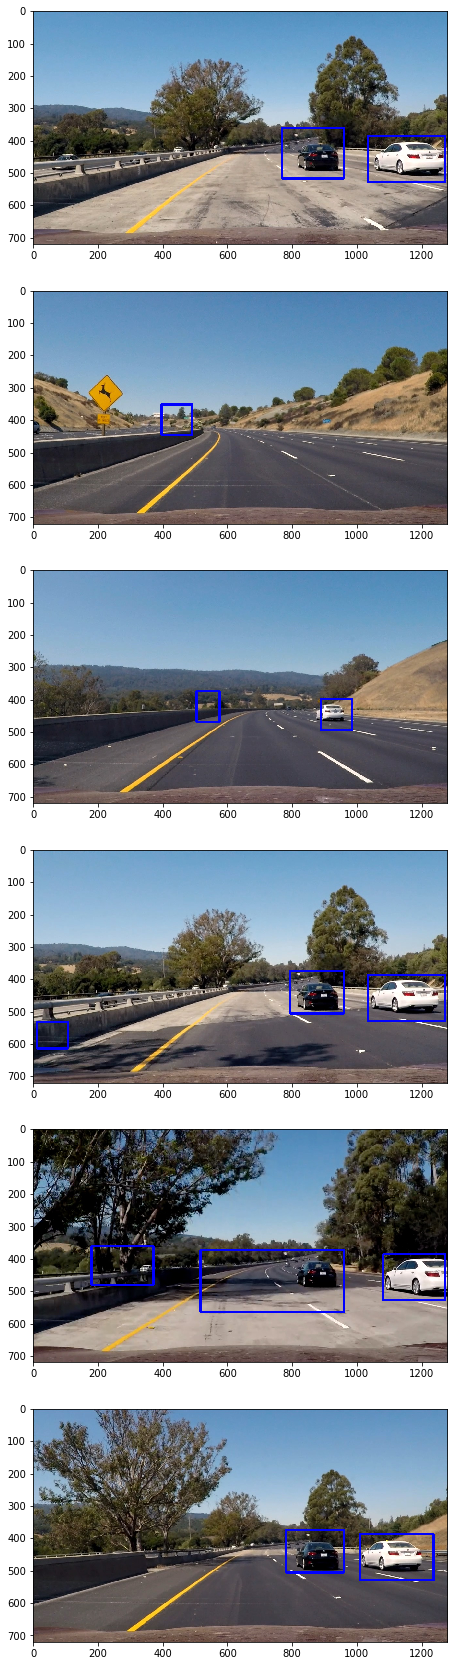

In [15]:
drawingcars = list(map(lambda BoxandCar: HeatAndLabelsOnCars(BoxandCar[0], BoxandCar[1], threshHold=1), zip(test_images, findingcars)))

DisplayImages(drawingcars)

#### Making Video output from video input

In [16]:
from moviepy.editor import VideoFileClip
from functools import reduce

class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    history = HeatHistory()

    def pipeline(img):
        boxes = find_cars(img, svc, scaler, parameters)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('project_video.mp4', 'project_output_video.mp4', threshhold=9)

[MoviePy] >>>> Building video project_output_video-test.mp4
[MoviePy] Writing video project_output_video-test.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [44:02<00:02,  2.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video-test.mp4 

